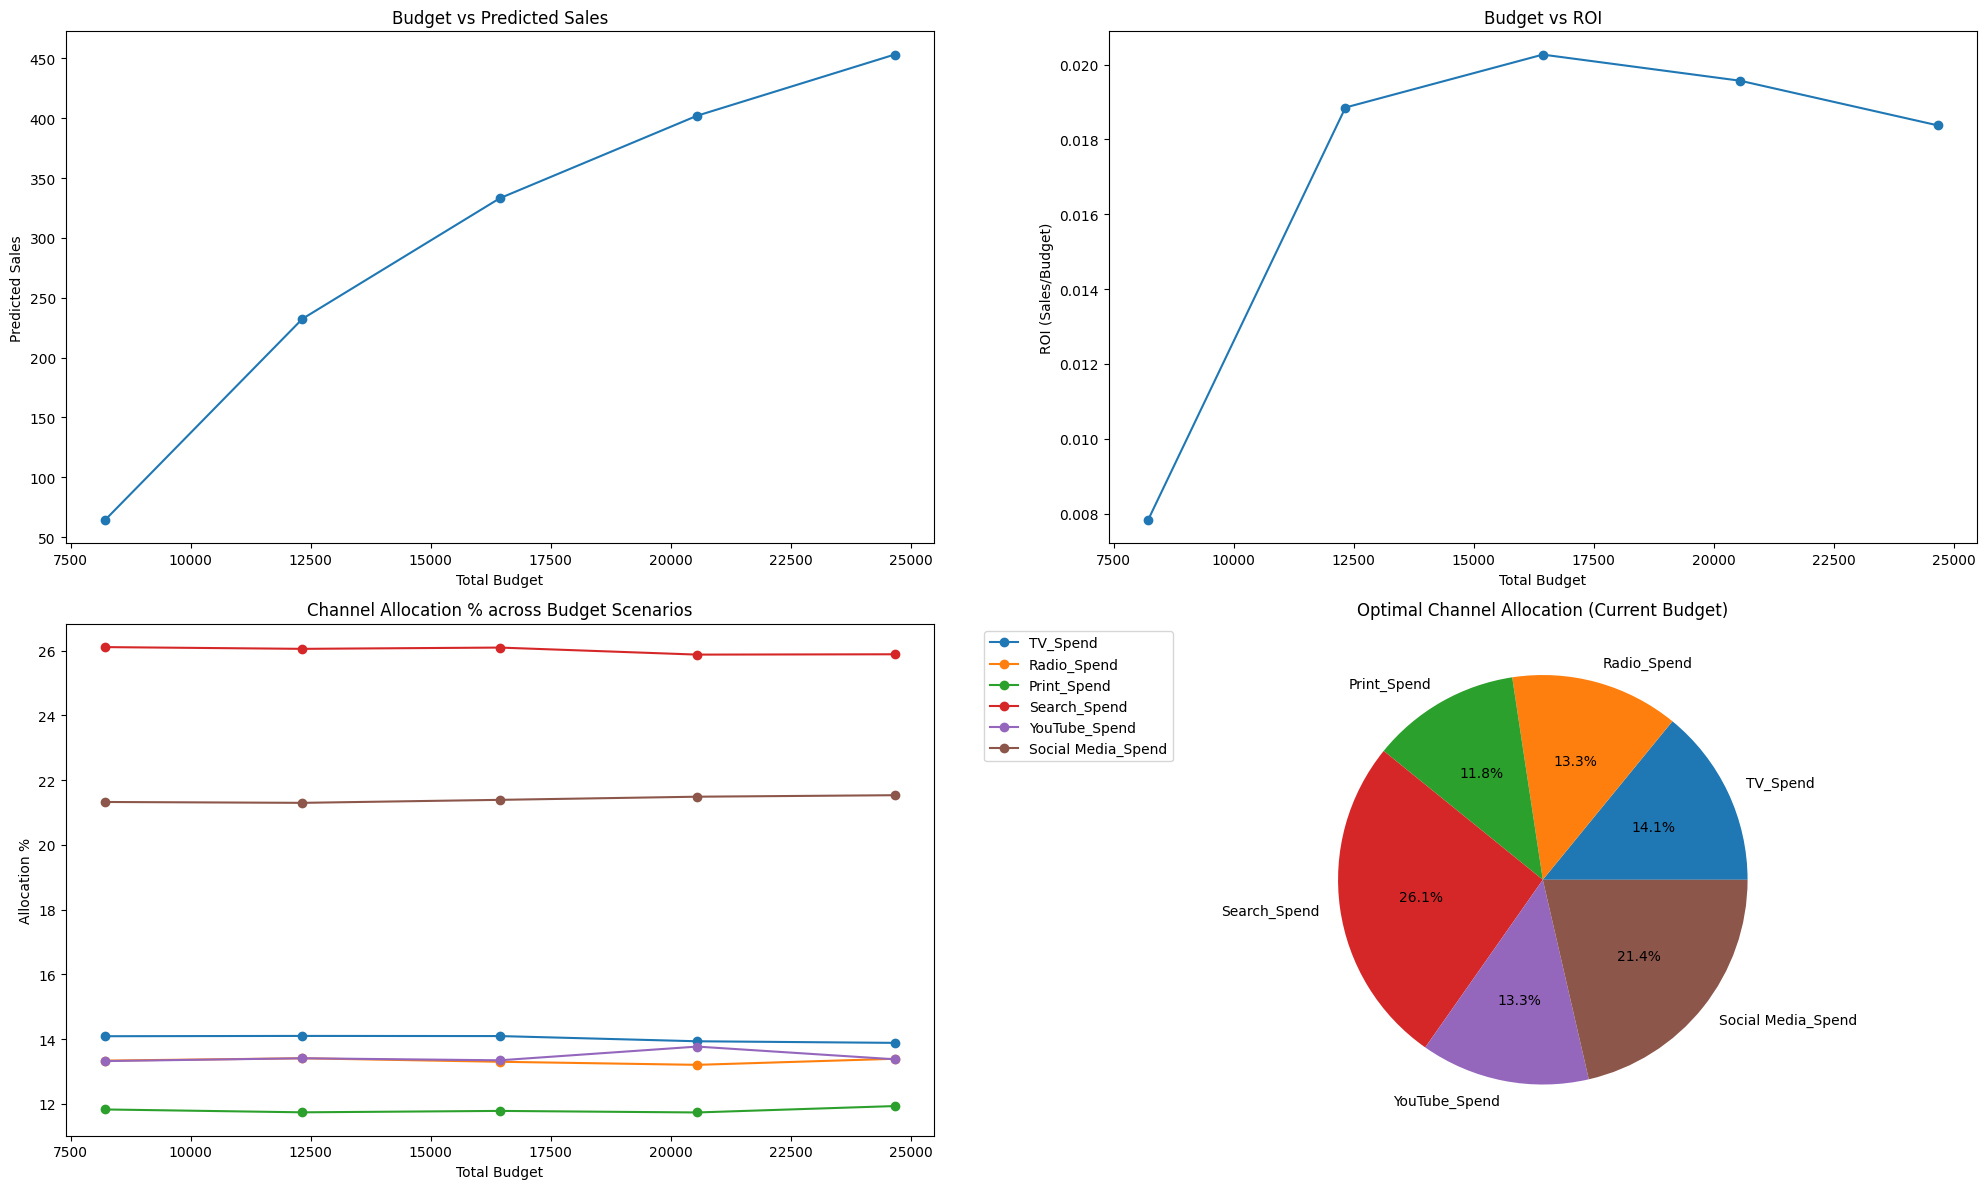


Optimization Results for Different Budget Scenarios:

Scenario 1 - Total Budget: $8,220.59
Predicted Sales: $64.38
ROI: 0.01

Channel Allocation:
TV_Spend: $1,158.01 (14.1%)
Radio_Spend: $1,095.98 (13.3%)
Print_Spend: $971.93 (11.8%)
Search_Spend: $2,146.67 (26.1%)
YouTube_Spend: $1,094.83 (13.3%)
Social Media_Spend: $1,753.17 (21.3%)
--------------------------------------------------

Scenario 2 - Total Budget: $12,330.89
Predicted Sales: $232.46
ROI: 0.02

Channel Allocation:
TV_Spend: $1,738.16 (14.1%)
Radio_Spend: $1,652.97 (13.4%)
Print_Spend: $1,446.99 (11.7%)
Search_Spend: $3,213.35 (26.1%)
YouTube_Spend: $1,652.97 (13.4%)
Social Media_Spend: $2,626.45 (21.3%)
--------------------------------------------------

Scenario 3 - Total Budget: $16,441.19
Predicted Sales: $333.18
ROI: 0.02

Channel Allocation:
TV_Spend: $2,316.79 (14.1%)
Radio_Spend: $2,186.19 (13.3%)
Print_Spend: $1,936.47 (11.8%)
Search_Spend: $4,290.94 (26.1%)
YouTube_Spend: $2,193.66 (13.3%)
Social Media_Spend: $3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# Load the data
df = pd.read_csv('/content/MMM brand data.csv')

# Define adstock transformation function
def adstock_transform(x, decay_rate):
    result = [x[0]]
    for i in range(1, len(x)):
        result.append(x[i] + decay_rate * result[i-1])
    return np.array(result)

# Define saturation transformation function (Hill function)
def saturation_transform(x, k, s):
    return x**s / (k**s + x**s)

# Initialize parameters
channels = ['TV_Spend', 'Radio_Spend', 'Print_Spend', 'Search_Spend', 'YouTube_Spend', 'Social Media_Spend']
decay_rates = {channel: 0.3 for channel in channels}
k_values = {channel: 0.5 for channel in channels}
s_values = {channel: 0.5 for channel in channels}

# Apply transformations
df_transformed = df.copy()
for channel in channels:
    df_transformed[f'{channel}_adstock'] = adstock_transform(df[channel].values, decay_rates[channel])
    df_transformed[f'{channel}_final'] = saturation_transform(
        df_transformed[f'{channel}_adstock'],
        k_values[channel],
        s_values[channel]
    )

# Prepare data for modeling
X = df_transformed[[f'{channel}_final' for channel in channels]]
y = df['Sales']
X['Promotion'] = df['Promotion']

# Fit linear regression model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X, y)

# Function to predict sales given spend
def predict_sales(spend_dict, promotion=0):
    transformed_spends = {}
    for channel in channels:
        adstock = adstock_transform(np.array([spend_dict[channel]]), decay_rates[channel])[0]
        transformed_spends[channel] = saturation_transform(adstock, k_values[channel], s_values[channel])

    X_pred = np.array([transformed_spends[channel] for channel in channels] + [promotion])
    return model.predict(X_pred.reshape(1, -1))[0]

# Optimization function for a given budget
def optimize_budget(total_budget):
    def objective_function(spend_vector):
        spend_dict = {channel: spend for channel, spend in zip(channels, spend_vector)}
        return -predict_sales(spend_dict)  # Negative because we're minimizing

    constraints = [
        {'type': 'eq', 'fun': lambda x: sum(x) - total_budget}  # Budget constraint
    ]
    bounds = [(0, total_budget) for _ in channels]  # Can't spend negative or more than budget

    initial_guess = np.array([total_budget/len(channels) for _ in channels])
    result = minimize(objective_function, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)

    return result.x, -result.fun  # Return optimal allocation and predicted sales

# Current total budget
current_budget = df[channels].sum().sum() / len(df)

# Generate different budget scenarios
budget_scenarios = np.linspace(current_budget * 0.5, current_budget * 1.5, 5)
optimization_results = []

for budget in budget_scenarios:
    allocation, predicted_sales = optimize_budget(budget)
    optimization_results.append({
        'Budget': budget,
        'Predicted_Sales': predicted_sales,
        'ROI': predicted_sales / budget,
        'Allocation': dict(zip(channels, allocation))
    })

# Convert results to DataFrame
results_df = pd.DataFrame(optimization_results)

# Visualizations
plt.figure(figsize=(20, 12))

# 1. Budget vs Sales
plt.subplot(2, 2, 1)
plt.plot(results_df['Budget'], results_df['Predicted_Sales'], marker='o')
plt.title('Budget vs Predicted Sales')
plt.xlabel('Total Budget')
plt.ylabel('Predicted Sales')

# 2. Budget vs ROI
plt.subplot(2, 2, 2)
plt.plot(results_df['Budget'], results_df['ROI'], marker='o')
plt.title('Budget vs ROI')
plt.xlabel('Total Budget')
plt.ylabel('ROI (Sales/Budget)')

# 3. Channel Allocation across Budgets
plt.subplot(2, 2, 3)
channel_allocations = pd.DataFrame([res['Allocation'] for res in optimization_results])
channel_allocations_pct = channel_allocations.div(channel_allocations.sum(axis=1), axis=0) * 100

for channel in channels:
    plt.plot(budget_scenarios, channel_allocations_pct[channel], marker='o', label=channel)
plt.title('Channel Allocation % across Budget Scenarios')
plt.xlabel('Total Budget')
plt.ylabel('Allocation %')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 4. Optimal Allocation for Current Budget
plt.subplot(2, 2, 4)
current_allocation = channel_allocations.iloc[2]  # Middle scenario (current budget)
plt.pie(current_allocation, labels=channels, autopct='%1.1f%%')
plt.title('Optimal Channel Allocation (Current Budget)')

plt.tight_layout()
plt.show()

# Print detailed results
print("\nOptimization Results for Different Budget Scenarios:")
for i, result in enumerate(optimization_results):
    print(f"\nScenario {i+1} - Total Budget: ${result['Budget']:,.2f}")
    print(f"Predicted Sales: ${result['Predicted_Sales']:,.2f}")
    print(f"ROI: {result['ROI']:.2f}")
    print("\nChannel Allocation:")
    for channel, amount in result['Allocation'].items():
        print(f"{channel}: ${amount:,.2f} ({amount/result['Budget']*100:.1f}%)")
    print("-" * 50)

# Calculate and print marginal returns
print("\nMarginal Returns Analysis:")
for i in range(1, len(optimization_results)):
    budget_increase = results_df['Budget'].iloc[i] - results_df['Budget'].iloc[i-1]
    sales_increase = results_df['Predicted_Sales'].iloc[i] - results_df['Predicted_Sales'].iloc[i-1]
    marginal_roi = sales_increase / budget_increase
    print(f"\nBudget Increase: ${budget_increase:,.2f}")
    print(f"Sales Increase: ${sales_increase:,.2f}")
    print(f"Marginal ROI: {marginal_roi:.2f}")